# Demonstration of sparse regularization for generation of pair-distribution function from noisy scattering data
## Matt Ware - mrware@stanford.edu

## Initialization

In [46]:
%matplotlib inline
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def CreateModelData(R0,QGRID,f=None):
    if f is None:
        f=np.exp(-QGRID**2/(2*2**2))
    
    S=np.sin(QGRID*R0)/(QGRID*R0)
    I=(S-np.nanmin(S)) *f**2*QGRID**2
    I=I/np.nanmax(I)
    I[np.isnan(I)]=np.zeros(I[np.isnan(I)].shape)+1
    return I

def PlotData(X,Y,xlabel='x',ylabel='y'):
    plt.close()
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.plot(np.array(X).flatten(),np.array(Y).flatten())
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def Histogram(Y,N=100):
    plt.close()
    for row in Y:
        plt.hist(row,N,normed=True, alpha=0.5)
    plt.show()    
    
def SampleDistribution(Model,Points,N):
    Model=Model/np.sum(Model)
    return np.random.choice(Points, N, p=Model)

def MonteCarlo(NExp,Model,Points,NSample=100):
    MC=np.zeros([NExp,NSample])
    for idx in range(NExp):
        MC[idx,:]=SampleDistribution(Model,Points,NSample)
    return MC
    
def MakeMean(Measurement):
    N=len(Measurement)
    Means=np.zeros_like(Measurement[0], dtype='float64')
    for idx in xrange(N):
        Means=Means+Measurement[idx]
    return Means/N
  
def MakeSTDs(Measurement,Means=None):
    N=len(Measurement)
    if Means is None:
        Means=MakeMean(Measurement)
        
    VARs=np.zeros_like(Measurement[0], dtype='float64')
    for idx in xrange(N):
        VARs=VARs+(Measurement[idx]-Means)**2
    return (VARs/N)**(1.0/2.0)

def ChiSquare(D,A,s):
    return np.sum(((D-A)/s)**2)/A.flatten().shape[0]

def ChiSquareMapping(D,F,w,s):
    A=FlexibleDot(w,F)
    return ChiSquare(D,A,s)

def JacChiSquareMapping(D,F,w0,s):
    NR = w0.flatten().shape[0]
    w=np.zeros([1,NR])
    w[0,:]=w0
#     print w.shape
    A=FlexibleDot(w,F)
    if A.shape[0] == D.shape[0]:
        Jac=2*FlexibleDot((A-D)/s,F)
    else:
        Jac=2*FlexibleDot((np.transpose(A)-D)/s,F)
        
#     print Jac
    if Jac.shape[0] == w.shape[0]:
        return np.sum(Jac,axis=1)/A.flatten().shape[0]
    else:
        return np.sum(Jac,axis=0)/A.flatten().shape[0]

def FlexibleDot(A,B):
    
    if A.shape[0] == B.shape[1]:
        return np.dot(np.transpose(A),np.transpose(B))          
    elif A.shape[0] == B.shape[0]:
        return np.dot(np.transpose(A),B)  
    elif A.shape[1] == B.shape[1]:
        return np.dot(A,np.transpose(B))
    elif A.shape[1] == B.shape[0]:
        return np.dot(A,B)
    raise ValueError
        

def CreateMapping(Rs,Qs,f=None):
    if f is None:
        f=np.exp(-Qs**2/(2*2**2))
        
    F0=np.array([scipy.special.spherical_jn(0, Qs*R) for R in Rs])
    F0=np.array([(F-np.min(F))*f**2*Qs**2 for F in F0])
#     F0=np.array([F0[idx,:]*Rs[idx]**2 for idx in xrange(Rs.shape[0])])
#     F0=np.array([(F-np.min(F))*f**2*Qs**2 for F in F0])
    return F0


def CreateDistributedModelData(QGRID,RGRID,DISTRO):
    N=len(RGRID)
    S=np.zeros_like(QGRID)
    for idx in xrange(N):
        S+=DISTRO[idx]*CreateModelData(RGRID[idx],QGRID)
    return S

#     return np.array([F/np.max(F) for F in F0])
#     return np.array([F/np.sum(F) for F in F0])
#     return np.array([F/np.linalg.norm(F) for F in F0])

## Theoretical pair-distribution function
We consider molecular iodine in a superposition of 3 electronic states with wavepackets at 2.7, 4.87, and 6.1 Angstroms having width 0.1 Angstroms.

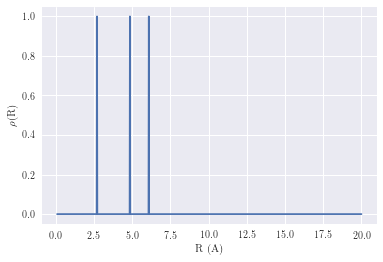

In [84]:
RGRID=np.linspace(0.1,20,1000)
w=1
w=0.001
DISTRO1=np.exp(-(RGRID-2.7)**2/(2.*w**2))
DISTRO1=DISTRO1/np.sum(DISTRO1)
DISTRO2=0.2*np.exp(-(RGRID-6.1)**2/(2.*w**2))
DISTRO2=DISTRO2/np.sum(DISTRO2)
DISTRO3=0.1*np.exp(-(RGRID-4.87)**2/(2.*w**2))
DISTRO3=DISTRO3/np.sum(DISTRO3)
DISTRO=DISTRO1+DISTRO2+DISTRO3
PlotData(RGRID,DISTRO,'R (A)',r"$\rho$(R)")


## Theoretical molecular scattering pattern

Generated from previous figure. We undersample this distribution using a Monte-Carlo to generate representative noisy experimental data

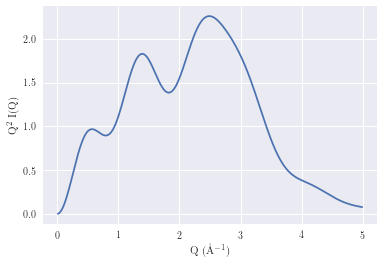

In [85]:
QGRID=np.arange(0.01,5,0.01)
# S=CreateModelData(2.7,QGRID)+0.2*CreateModelData(6.1,QGRID)+0.1*CreateModelData(4.87,QGRID)
S=CreateDistributedModelData(QGRID,RGRID,DISTRO)
PlotData(QGRID,S,r"Q (\AA$^{-1}$)",r"Q$^2$ I(Q)")
# S=CreateModelData(2.8,QGRID)+0.5*CreateModelData(6.1,QGRID)
# PlotData(QGRID,S)

## Monte-Carlo generation of simulated experimental data

In [110]:
NExps=50
MC=MonteCarlo(NExps,S,QGRID,NSample=50)
# Histogram(MC,N=50)

In [111]:
QMeasurement=np.linspace(.23,5.37,50)
Measurement=np.array([np.histogram(row,QMeasurement)[0] for row in MC])
QBins=QMeasurement+(QMeasurement[1]-QMeasurement[0])/2.0
QBins=QBins[0:-1]

Means=MakeMean(Measurement)
STDs=MakeSTDs(Measurement,Means)

ValidIdxs=(Means > .1) & (STDs > .1)
QBins=QBins[ValidIdxs]
Means=Means[ValidIdxs]
STDs=STDs[ValidIdxs]


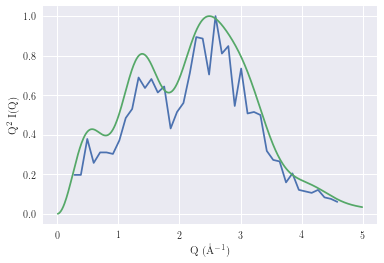

In [112]:
plt.close()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(QBins,Means/np.max(Means))
plt.plot(QGRID,S/np.max(S))
plt.xlabel(r"Q (\AA$^{-1}$)")
plt.ylabel('Q$^2$ I(Q)')
plt.show()


# PlotData(QBins,STDs)

## Generate basis of zeroth-order Spherical bessel functions
To recover the pair-distribution function, we 

(1) Minimize $$\chi^2=\frac{1}{2} \sum_J \left( \frac{(F\cdot w)_J-D_J}{\sigma_J}\right)^2,$$ where $D_J$ are the observed values above with standard deviation $\sigma_J$ and $F$ is the basis of Spherical bessel functions weighted by the predicted $w$.

(2) Minimize $$ S=-\sum_J  U_J -2 w_J \log(U_J+w_J),$$ where $U_J=\sqrt{w_J^2+4}$, subject to $\chi^2 \le \chi_0^2$, where $\chi_0$ is the optimal value obtained in (1).

This follows a common procedure for Abel Transforming VMI data (DOI: 10.1039/C3CP53673D). The important difference from that work is instead of using the linear transform which generates the Abel transform, we use the linear transform (ie. Spherical bessel functions) which generate the pair-distribution function. By minimizing the entropy above, we are maximizing the probability that our obtained reconstruction is the true reconstruction for the data, ie. global maxima.

### Sample zeroth order Spherical Bessels plotted

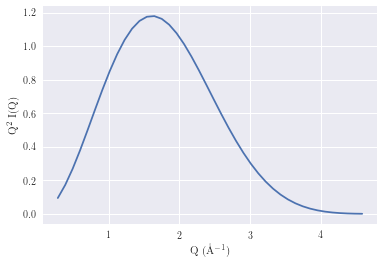

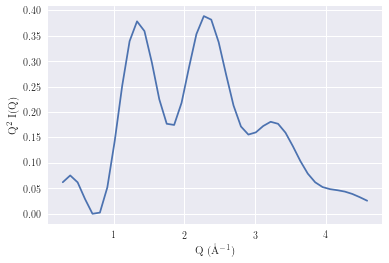

In [113]:
NR=150
RBins=np.linspace(0.89,9.,NR)
F = CreateMapping(RBins,QBins)
PlotData(QBins,F[1,:],r"Q (\AA$^{-1}$)",r"Q$^2$ I(Q)")
PlotData(QBins,F[94,:],r"Q (\AA$^{-1}$)",r"Q$^2$ I(Q)")

## Make a guess for initial distribution

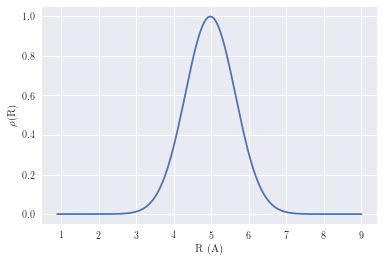

In [114]:
w=np.exp(-(np.arange(NR)-NR/2.)**2/NR/2)
w=w/np.max(w)
PlotData(RBins,w,'R (A)',r"$\rho$(R)")

## Perform initial optimization
(1) Minimize $$\chi^2=\frac{1}{2} \sum_J \left( \frac{(F\cdot w)_J-D_J}{\sigma_J}\right)^2,$$ where $D_J$ are the observed values above with standard deviation $\sigma_J$ and $F$ is the basis of Spherical bessel functions weighted by the predicted $w$.



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0205572330913
            Iterations: 84
            Function evaluations: 12769
            Gradient evaluations: 84


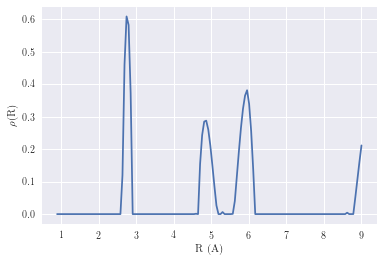

In [115]:
# 
def func_deriv(w,Means,F,STDs):
    return JacChiSquareMapping(Means,F,w,STDs)

def func(w,Means,F,STDs):
    return ChiSquareMapping(Means,F,w,STDs)

L0=100
cons = ({'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - L0]),
         'jac' : lambda x: np.array([0.0, 1.0])})

bnds = [(0, None) for el in w]

res = scipy.optimize.minimize(func, w, args=(Means,F,STDs),  bounds=bnds,\
                   method='SLSQP', options={'disp': True,'maxiter':10000})

PlotData(RBins,res.x,'R (A)',r"$\rho$(R)")

## Perform entropy maximization

(2) Minimize $$ S=-\sum_J  U_J -2 w_J \log(U_J+w_J),$$ where $U_J=\sqrt{w_J^2+4}$, subject to $\chi^2 \le \chi_0^2$, where $\chi_0$ is the optimal value obtained in (1).

L0 is ... 0.020557
Upper bound for L0 is ... 0.002056
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.77920646903
            Iterations: 22
            Function evaluations: 3200
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.2547638195
            Iterations: 40
            Function evaluations: 5933
            Gradient evaluations: 39
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7.61131586562
            Iterations: 64
            Function evaluations: 9757
            Gradient evaluations: 63
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.44467407394
            Iterations: 46
            Function evaluations: 6846
            Gradient evaluations: 45
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -8.21701173859
     

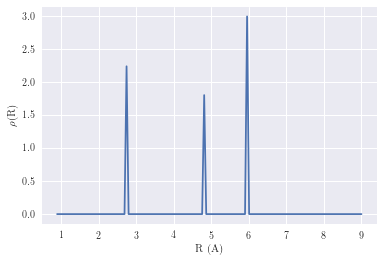

0.0226129564004


In [116]:
def func_deriv(w,Means,F,STDs):
    return JacChiSquareMapping(Means,F,w,STDs)

def func(w,Means,F,STDs):
    return ChiSquareMapping(Means,F,w,STDs)

def nS(w):
#     return -np.sum(np.abs(w))
#     return np.sum(w*np.log(w))
    U=np.sqrt(w**2+4)
    Inner=U-2-w*np.log(U+w)
    return np.sum(Inner)

def nS_grad(w):
#     return -np.sign(w)
#     return np.log(w)+1
    U=np.sqrt(w**2+4)
#     print U
    Inner=w/U-np.log(U+w)-(1+w/U)*w/(U+w)
    return Inner

L0=func(res.x,Means,F,STDs)
tol=L0/10.
print 'L0 is ... %f' % L0 
print 'Upper bound for L0 is ... %f' % (-func(res.x,Means,F,STDs) + (L0 + tol))

cons = ({'type': 'ineq',
         'fun' : lambda x: -func(x,Means,F,STDs) + (L0 + tol)})

bnds = [(0, None) for el in w]

minimizer_kwargs = {"method": "SLSQP","bounds":bnds,"constraints":cons,
                    "options":{'disp': True,'maxiter':500,'ftol':1e-10}}
res2 = scipy.optimize.basinhopping(nS, res.x, minimizer_kwargs=minimizer_kwargs,
                   niter=10,T=.1,stepsize=1000)

PlotData(RBins,res2.x,'R (A)',r"$\rho$(R)")
print func(res2.x,Means,F,STDs)

## Print the discovered peak locations of the reconstructed pair-distribution function

In [117]:
IdxPeaks = np.abs(res2.x) > 0.01
Rs=RBins[IdxPeaks]
print Rs


[ 2.74060403  4.80892617  5.95194631]
